# 1. Imports

In [85]:
import psycopg2 as pg
import pandas   as pd
import numpy    as np
import seaborn  as sns
import os 

from dotenv                import load_dotenv
from IPython.core.display  import HTML
from IPython.display       import Image

from matplotlib            import pyplot as plt

## 1.1.Helper Functions

In [97]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

In [98]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\gutsc\anaconda3\envs\Health_Insurance\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.2. Collect Data Using Psycopg2

In [82]:
# DB Credentials
load_dotenv()

host = os.environ.get( 'host' )
port = os.environ.get( 'port' )
database = os.environ.get( 'database' )
username = os.environ.get( 'user' )
pwd = os.environ.get( 'pwd' )

In [3]:
# create DB connection
conn = pg.connect( user=username,
                   password=pwd,
                   host=host,
                   port=port,
                   database=database )

### 1.2.1. Schema Query

In [4]:
# create cursor and execute query
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute( query_schema )
record = cursor.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

### 1.2.2. Tables Query 

In [5]:
# create cursor and execute query
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""

cursor.execute( query_tables )
record = cursor.fetchall()
record

[('users',), ('vehicle',), ('insurance',)]

### 1.2.3. Collect Data

In [6]:
# create cursor and execute query
cursor = conn.cursor()

query_tables_users = """
    SELECT *
    FROM pa004.users u
    LIMIT 10
"""

cursor.execute( query_tables_users )
record = cursor.fetchall()
record

[(1, 'Male', 44, 28.0, 26.0),
 (2, 'Male', 76, 3.0, 26.0),
 (3, 'Male', 47, 28.0, 26.0),
 (4, 'Male', 21, 11.0, 152.0),
 (5, 'Female', 29, 41.0, 152.0),
 (6, 'Female', 24, 33.0, 160.0),
 (7, 'Male', 23, 11.0, 152.0),
 (8, 'Female', 56, 28.0, 26.0),
 (9, 'Female', 24, 3.0, 152.0),
 (10, 'Female', 32, 6.0, 152.0)]

In [7]:
# close cursor and connection
cursor.close()
conn.close()

In [8]:
# convert to dataframe
data = pd.DataFrame( record )
data.head()

,0,1,2,3,4
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


## 1.3. Collect Data Using Pandas

In [39]:
# create DB connection
conn = pg.connect( user=username,
                   password=pwd,
                   host=host,
                   port=port,
                   database=database )

In [40]:
# users table query
query = """
    SELECT *
    FROM pa004.users
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [41]:
# vehicle table query
query = """
    SELECT *
    FROM pa004.vehicle
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [42]:
# insurance table query
query = """
    SELECT *
    FROM pa004.insurance
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [43]:
# join tables
query = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle v ON ( u.id = v.id )
                       LEFT JOIN pa004.insurance i ON ( u.id = i.id )
"""

df_raw = pd.read_sql( query, conn )
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [44]:
# close cursor and connection
cursor.close()
conn.close()

In [45]:
# saving dataset
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.to_csv("./data/data.csv", encoding='utf-8', index=False)

## 1.4. Loading Data 

In [61]:
df1 = pd.read_csv( 'data/data.csv')
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 2. Data Description

In [118]:
df2 = df1.copy()

## 2.1. Renaming Columns

In [63]:
# to lower case
cols_new = df_raw.columns.str.lower()

# rename columns
df2.columns = cols_new
df2.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 2.2. Data Dimensions

In [64]:
print( f'Number of rows: {df2.shape[0]}'  )
print( f'Number of columns: {df2.shape[1]}'  )

Number of rows: 381109
Number of columns: 12


## 2.3. Data Types

In [65]:
df2.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.4. Check NA

In [66]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.5. Descriptive Statistics

### 2.5.1. Numerical Attributes

In [100]:
# dataset with only numerical attributes
num_attributes = df2.select_dtypes( include=[ 'int64', 'float64' ] )
num_attributes.head()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
0,7,23,11.0,152.0,1,0,23367.0,249,0
1,13,41,15.0,14.0,1,1,31409.0,221,0
2,18,25,35.0,152.0,1,1,46622.0,299,0
3,31,26,8.0,160.0,1,0,2630.0,136,0
4,39,45,8.0,124.0,1,0,42297.0,264,0


In [68]:
# Central Tendency
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
summary = pd.concat([_min, _max, _range, _mean, _median, _std, _skew, _kurtosis]).T.reset_index()
summary.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


* Although "driving_license", "previously_insured" and "response" have numerical values, they are considered as categorical attributes, because the numbers represent categories.

### 2.5.2 Categorical Attributes

In [105]:
cat_attributes = df2[['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'previously_insured', 'response']]
cat_attributes.head()

,gender,vehicle_age,vehicle_damage,driving_license,previously_insured,response
0,Male,< 1 Year,Yes,1,0,0
1,Female,1-2 Year,No,1,1,0
2,Female,< 1 Year,No,1,1,0
3,Female,< 1 Year,No,1,0,0
4,Male,1-2 Year,Yes,1,0,0


In [106]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                2
vehicle_age           3
vehicle_damage        2
driving_license       2
previously_insured    2
response              2
dtype: int64

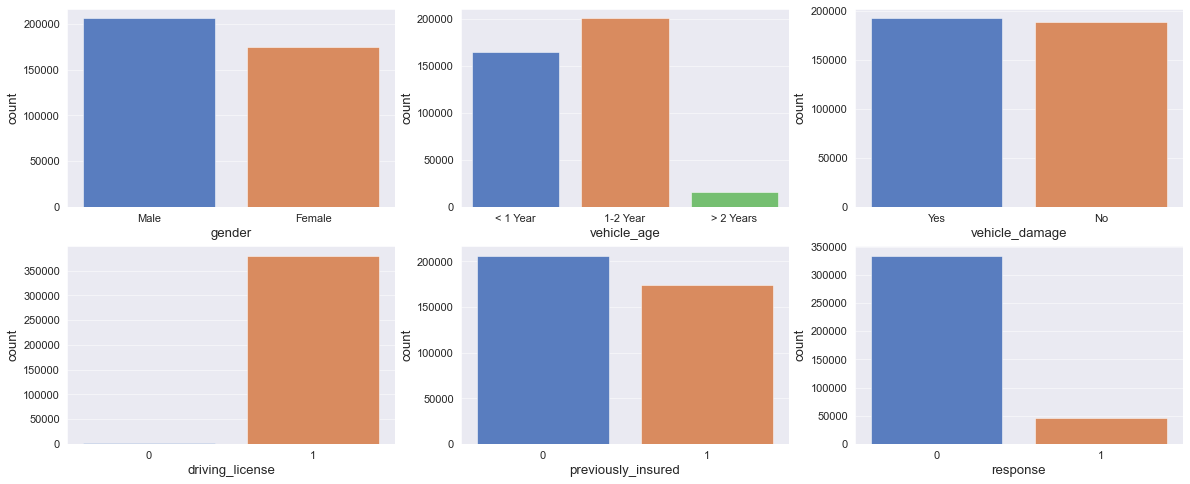

In [116]:
fig, axes = plt.subplots(2,3)

sns.countplot( x='gender'             , data=cat_attributes, ax=axes[0,0] )
sns.countplot( x='vehicle_age'        , data=cat_attributes, ax=axes[0,1] )
sns.countplot( x='vehicle_damage'     , data=cat_attributes, ax=axes[0,2] )
sns.countplot( x='driving_license'    , data=cat_attributes, ax=axes[1,0] )
sns.countplot( x='previously_insured' , data=cat_attributes, ax=axes[1,1] )
sns.countplot( x='response'           , data=cat_attributes, ax=axes[1,2] );

# 3. Feature Engineering

In [119]:
df3 = df2.copy()

## 3.1. Creating New Features

In [120]:
# vehicle age
df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years'      if x == '> 2 years' else
                                                         'between_1_2_years' if x == '1-2 years' else 
                                                         'below_1_year' )

# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


# check
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,below_1_year,0,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,below_1_year,1,0,42297.0,264,0


# 4. Data Filtering

In [121]:
df4 = df3.copy()

# 5. EDA

# 6. Feature Selection

# 7. Data Preparation

# 8. Machine Learning Model